In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score, confusion_matrix, classification_report, recall_score, precision_score

In [6]:
train_df = pd.read_csv(r'C:\Users\ixz407\OneDrive - University of Birmingham\Dissertation\Machine Learning\Dissertation\Tables\bnpl_train.csv')
test_df = pd.read_csv(r'C:\Users\ixz407\OneDrive - University of Birmingham\Dissertation\Machine Learning\Dissertation\Tables\bnpl_test.csv')
val_df = pd.read_csv(r'C:\Users\ixz407\OneDrive - University of Birmingham\Dissertation\Machine Learning\Dissertation\Tables\bnpl_val.csv')
target_col = "default_flag"

In [7]:
print(train_df.shape, test_df.shape, val_df.shape)
print(train_df.head(),test_df.head(), val_df.head())
print("Train nulls in target:", train_df["default_flag"].isna().sum())
print("Train class distribution:\n", train_df["default_flag"].value_counts(normalize=True))

(595, 16) (199, 16) (199, 16)
   failed_traditional_credit  external_repayment_loans  \
0                          1                         1   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         1   

   credit_card_interest_incidence  default_flag  bnpl_usage_frequency  \
0                               0             0             -0.730258   
1                               0             0              1.319109   
2                               0             0              0.408279   
3                               1             0             -1.641088   
4                               1             0              0.408279   

   financial_stress_score  credit_limit_utilisation  \
0               -1.246089                 -1.746734   
1                0.529472                 -0.222965   
2                

In [8]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("X_train shape:", X_train.shape, X_train.head())
print("y_train shape:", y_train.shape, y_train.head())
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
print("X_test shape:", X_test.shape, X_test.head())
print("y_test shape:", y_test.shape, y_test.head())
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
print("X_val shape:", X_val.shape, X_val.head())
print("y_val shape:", y_val.shape, y_val.head())

X_train shape: (595, 15)    failed_traditional_credit  external_repayment_loans  \
0                          1                         1   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         1   

   credit_card_interest_incidence  bnpl_usage_frequency  \
0                               0             -0.730258   
1                               0              1.319109   
2                               0              0.408279   
3                               1             -1.641088   
4                               1              0.408279   

   financial_stress_score  credit_limit_utilisation  \
0               -1.246089                 -1.746734   
1                0.529472                 -0.222965   
2                1.239697                  0.805578   
3                1.594809                 -0.184871

In [9]:
print(X_train.isnull().sum().sum())  # should be 0


0


In [10]:
k_values = range(2, 13)
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=500)
    kmeans.fit(X_train)
    labels = kmeans.labels_
    
    inertia = kmeans.inertia_
    sil = silhouette_score(X_train, labels)
    ch = calinski_harabasz_score(X_train, labels)
    db = davies_bouldin_score(X_train, labels)
    
    results.append({"k": k, "inertia": inertia, "silhouette": sil, "CH": ch, "DB": db})

results_df = pd.DataFrame(results)
print(results_df)

     k      inertia  silhouette         CH        DB
0    2  6970.840640    0.065595  42.478121  3.673248
1    3  6561.001428    0.078054  41.017647  3.069163
2    4  6174.466369    0.087949  41.340508  2.690005
3    5  5912.761332    0.086000  38.851432  2.518384
4    6  5655.371716    0.088563  37.802009  2.441285
5    7  5449.417296    0.085321  36.340535  2.356964
6    8  5305.479489    0.083615  34.214739  2.301488
7    9  5160.865483    0.081014  32.776922  2.193783
8   10  5048.397714    0.081979  31.181348  2.156170
9   11  4936.984336    0.079617  29.965382  2.131601
10  12  4799.907581    0.084762  29.484825  2.056938


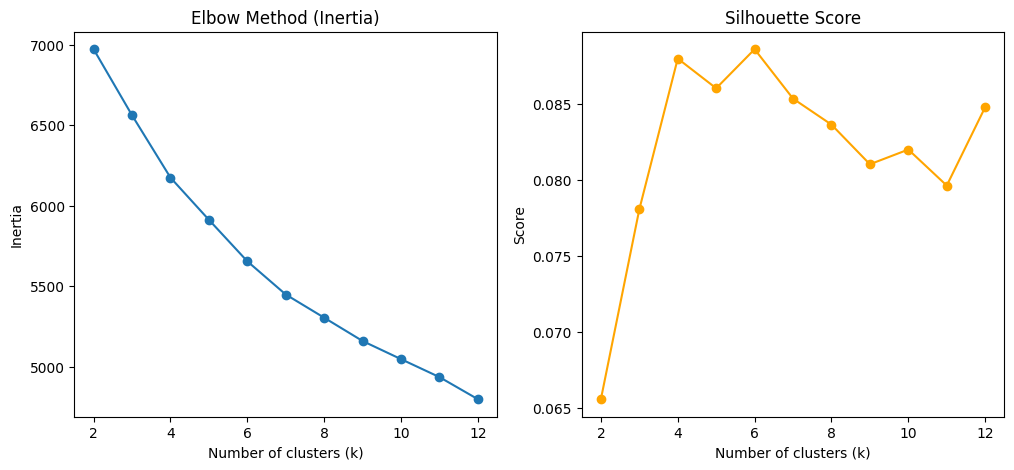

In [11]:


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(results_df["k"], results_df["inertia"], marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(results_df["k"], results_df["silhouette"], marker='o', color='orange')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")

plt.show()

In [12]:
# Step 3.1 — Combine train + validation features for final training
X_trainval = np.vstack([X_train, X_val])

# Step 3.2 — Fit final k-means model
final_kmeans = KMeans(
    n_clusters=6, init="k-means++", n_init=50, max_iter=500, random_state=42
)
final_kmeans.fit(X_trainval)

# Step 3.3 — Assign clusters to each split
train_clusters = final_kmeans.predict(X_train)
val_clusters   = final_kmeans.predict(X_val)
test_clusters  = final_kmeans.predict(X_test)

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1776.0_x64__qbz5n2kfra8p0\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1776.0_x64__qbz5n2kfra8p0\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1776.0_x64__qbz5n2kfra8p0\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [13]:
K_train=train_df.copy()
K_train['cluster'] = train_clusters
K_val=val_df.copy()
K_val['cluster'] = val_clusters
K_test=test_df.copy()
K_test['cluster'] = test_clusters

In [14]:
def cluster_default_rates(df):
    return df.groupby("cluster")["default_flag"].agg(
        cluster_size="count",
        default_rate="mean"
    ).sort_values("default_rate", ascending=False)

train_cluster_stats = cluster_default_rates(K_train)
val_cluster_stats   = cluster_default_rates(K_val)
test_cluster_stats  = cluster_default_rates(K_test)

print("Train Cluster Default Rates:\n", train_cluster_stats)
print("\nValidation Cluster Default Rates:\n", val_cluster_stats)
print("\nTest Cluster Default Rates:\n", test_cluster_stats)


Train Cluster Default Rates:
          cluster_size  default_rate
cluster                            
2                 113      0.283186
1                  87      0.103448
4                 108      0.027778
0                  94      0.021277
3                  92      0.000000
5                 101      0.000000

Validation Cluster Default Rates:
          cluster_size  default_rate
cluster                            
2                  40      0.275000
4                  39      0.076923
1                  32      0.062500
0                  25      0.000000
3                  33      0.000000
5                  30      0.000000

Test Cluster Default Rates:
          cluster_size  default_rate
cluster                            
2                  40      0.200000
1                  40      0.125000
0                  22      0.090909
4                  33      0.030303
3                  36      0.000000
5                  28      0.000000


In [15]:
# Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,      # Let it grow until pure leaves or min_samples constraints
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(K_train, y_train)

# Predictions
rf_preds = rf_model.predict(K_test)
rf_probs = rf_model.predict_proba(K_test)[:, 1]

# Evaluation
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))
print("ROC AUC Score:", roc_auc_score(y_test, rf_probs))
print("Average Precision Score:", average_precision_score(y_test, rf_probs))
print("F1 Score:", f1_score(y_test, rf_preds))
print("Recall Score:", recall_score(y_test, rf_preds))
print("Precision Score:", precision_score(y_test, rf_preds))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       183
           1       1.00      1.00      1.00        16

    accuracy                           1.00       199
   macro avg       1.00      1.00      1.00       199
weighted avg       1.00      1.00      1.00       199

Confusion Matrix:
 [[183   0]
 [  0  16]]
ROC AUC Score: 1.0
Average Precision Score: 1.0
F1 Score: 1.0
Recall Score: 1.0
Precision Score: 1.0


In [16]:
# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(K_train, y_train)

# Predictions
xgb_preds = xgb_model.predict(K_test)
xgb_probs = xgb_model.predict_proba(K_test)[:, 1]

# Evaluation
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_preds))
print("ROC AUC Score:", roc_auc_score(y_test, xgb_probs))
print("Average Precision Score:", average_precision_score(y_test, xgb_probs))
print("F1 Score:", f1_score(y_test, xgb_preds))
print("Recall Score:", recall_score(y_test, xgb_preds))
print("Precision Score:", precision_score(y_test, xgb_preds))


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       183
           1       1.00      1.00      1.00        16

    accuracy                           1.00       199
   macro avg       1.00      1.00      1.00       199
weighted avg       1.00      1.00      1.00       199

Confusion Matrix:
 [[183   0]
 [  0  16]]
ROC AUC Score: 1.0
Average Precision Score: 1.0
F1 Score: 1.0
Recall Score: 1.0
Precision Score: 1.0


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1776.0_x64__qbz5n2kfra8p0\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:42:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
